## Alias-Free-GAN Encoder

### Generator

- Paper: [Alias-Free Generative Adversarial Networks](https://arxiv.org/abs/2106.12423) (2021)


### Encoder
- Paper: [In-Domain GAN Inversion for Real Image Editing](https://arxiv.org/abs/2004.00049) (ECCV 2020)

- Encoder: domain-guided encoder 
- Domain-regularized Optimization
- Inverion to $W$ space (NOT extended $W+$ space)
- pretrained model: [`encoder-250k`](https://drive.google.com/file/d/17mwABMONSQfTj2fpgiFdAPd6giXAGBi3/view?usp=sharing)

In [ ]:
# For Colab

!git clone https://github.com/happy-jihye/alias-free-gan-encoder.git
!pip install ftfy regex tqdm ninja gdown tensorfn

%cd alias-free-gan-encoder

# download pretrained model
from utils import download_pretrained_model

download_pretrained_model("encoder-250k.pt")
download_pretrained_model("jugyeong-30k.pt")
!wget https://www.dropbox.com/s/ydqw5pb6cu7trxt/config-t_800k.pt?dl=0 -O checkpoints/ffhq-800k.pt


## Load Model

In [52]:
import os
import torch
from torchvision import utils, transforms
from torch import optim
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
from utils import save_image, imshow, tensor2image

from stylegan2.model import PixelNorm, EqualLinear, EqualConv2d
from stylegan2.op import conv2d_gradfix, upfirdn2d, fused_leaky_relu

import stylegan2.lpips as lpips


In [53]:
from model import Generator
from config import GANConfig

device = "cuda"

# -------------
# Generator
# -------------

ckpt = "checkpoints/encoder-250k.pt"

ckpt = torch.load(ckpt, map_location=lambda storage, loc: storage)
conf = GANConfig(**ckpt["g_conf"])
generator = conf.generator.make().to(device)
generator.load_state_dict(ckpt["g_ema"], strict=False)

# -------------
# Encoder
# -------------

from stylegan2.model import Encoder

size=256

encoder = Encoder(size, 512).to(device)
encoder.load_state_dict(ckpt['e'])
encoder.eval()

Encoder(
  (convs): Sequential(
    (0): ConvLayer(
      (0): EqualConv2d(3, 64, 1, stride=1, padding=0)
      (1): FusedLeakyReLU()
    )
    (1): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(64, 64, 3, stride=1, padding=1)
        (1): FusedLeakyReLU()
      )
      (conv2): ConvLayer(
        (0): Blur()
        (1): EqualConv2d(64, 128, 3, stride=2, padding=0)
        (2): FusedLeakyReLU()
      )
      (skip): ConvLayer(
        (0): Blur()
        (1): EqualConv2d(64, 128, 1, stride=2, padding=0)
      )
    )
    (2): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(128, 128, 3, stride=1, padding=1)
        (1): FusedLeakyReLU()
      )
      (conv2): ConvLayer(
        (0): Blur()
        (1): EqualConv2d(128, 256, 3, stride=2, padding=0)
        (2): FusedLeakyReLU()
      )
      (skip): ConvLayer(
        (0): Blur()
        (1): EqualConv2d(128, 256, 1, stride=2, padding=0)
      )
    )
    (3): ResBlock(
      (conv1): ConvLayer(
        (0): 

## Project Images to Latent Spaces by Domain-Guided Encoder

In [54]:
step=1000

# -----------------------------------
# Project Images to Latent spaces
# -----------------------------------
    

n_mean_latent = 10000

# Load Real Images
resize = min(size, 256)

transform = transforms.Compose(
    [
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)


If you want to project your own images, align your images.

- [`FFHQ-Alignment`](https://github.com/happy-jihye/FFHQ-Alignment)

initial projections:


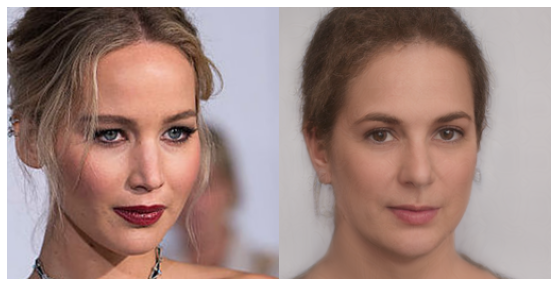

In [55]:

imgfile='sample/align-celeb-2.jpg'

img = transform(Image.open(imgfile).convert("RGB"))
imgs = img.unsqueeze(0).to(device)


truncation = 0.5
trunc = generator.mean_latent(4096).detach().clone()

with torch.no_grad():
    z0 = encoder(imgs)
    imgs_gen = generator(z0, 
                             input_is_latent=True,
                             truncation=truncation,
                             truncation_latent=trunc,)

imgs_real = torch.cat([img for img in imgs], dim=1)
imgs_fakes = torch.cat([img_gen for img_gen in imgs_gen], dim=1)

print('initial projections:')
imshow(tensor2image(torch.cat([imgs_real, imgs_fakes], dim=2)),5)

## Domain-Regularized Optimization

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 10%|▉         | 99/1000 [00:15<02:17,  6.57it/s]

step:100, loss:2.8573951721191406


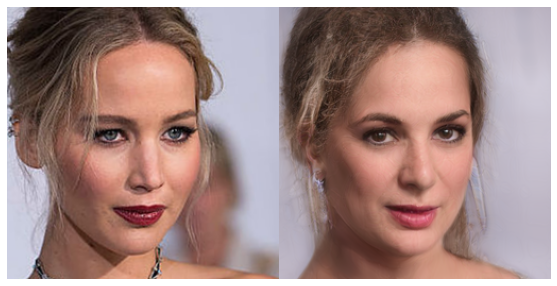

 20%|█▉        | 199/1000 [00:30<02:03,  6.49it/s]

step:200, loss:2.627528190612793


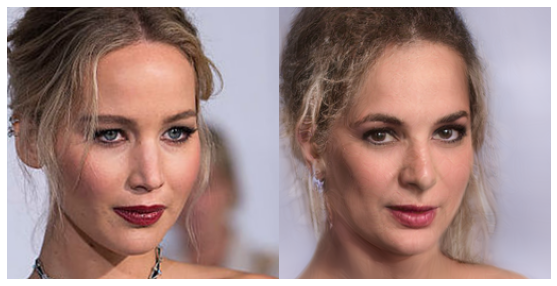

 30%|██▉       | 299/1000 [00:46<01:48,  6.47it/s]

step:300, loss:2.5595598220825195


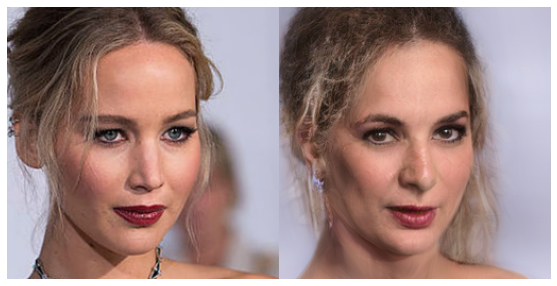

 40%|███▉      | 399/1000 [01:01<01:32,  6.50it/s]

step:400, loss:2.501908540725708


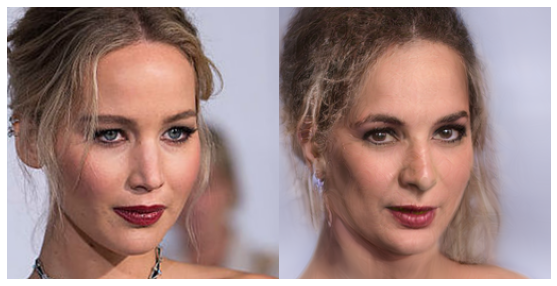

 50%|████▉     | 499/1000 [01:17<01:16,  6.52it/s]

step:500, loss:2.4657540321350098


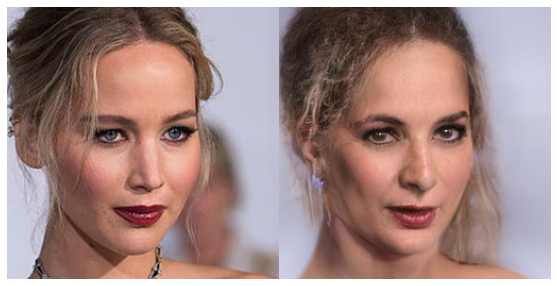

 60%|█████▉    | 599/1000 [01:33<01:01,  6.50it/s]

step:600, loss:2.421588897705078


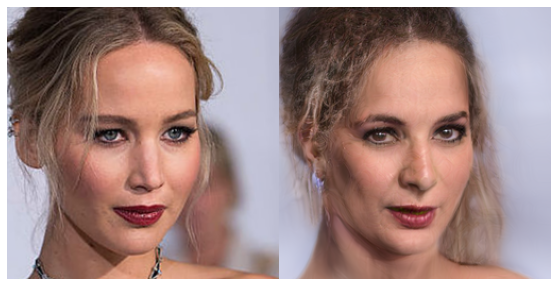

 70%|██████▉   | 699/1000 [01:48<00:46,  6.49it/s]

step:700, loss:2.391955614089966


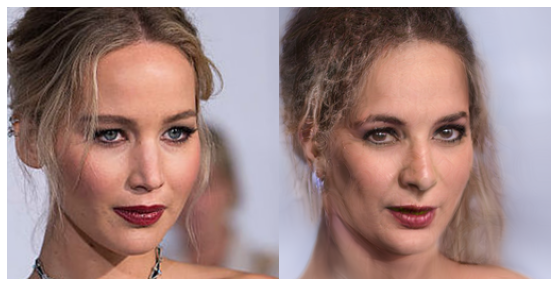

 80%|███████▉  | 799/1000 [02:04<00:31,  6.48it/s]

step:800, loss:2.368793487548828


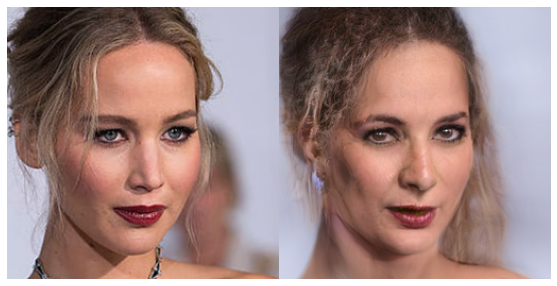

 90%|████████▉ | 899/1000 [02:20<00:15,  6.53it/s]

step:900, loss:2.352531909942627


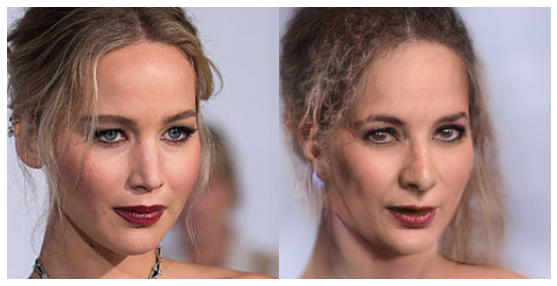

100%|█████████▉| 999/1000 [02:35<00:00,  6.49it/s]

step:1000, loss:2.338794231414795


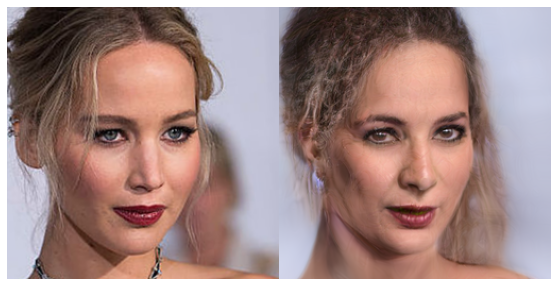

100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


In [10]:

from train_encoder import VGGLoss
import torch.nn.functional as F

vgg_loss = VGGLoss(device)

z = z0.detach().clone()

z.requires_grad = True
optimizer = torch.optim.Adam([z], lr=0.01)

pbar = tqdm(range(1000))

for step in pbar:
    imgs_gen= generator(z, 
                           input_is_latent=True, 
                           truncation=truncation,
                           truncation_latent=trunc)

    z_hat = encoder(imgs_gen)
    
    loss = F.mse_loss(imgs_gen, imgs) + vgg_loss(imgs_gen, imgs) + F.mse_loss(z0, z_hat)*2.0
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    
    if (step+1)%100 == 0:
        print(f'step:{step+1}, loss:{loss.item()}')
        imgs_fakes = torch.cat([img_gen for img_gen in imgs_gen], dim=1)        
        imshow(tensor2image(torch.cat([imgs_real, imgs_fakes], dim=2)),5)

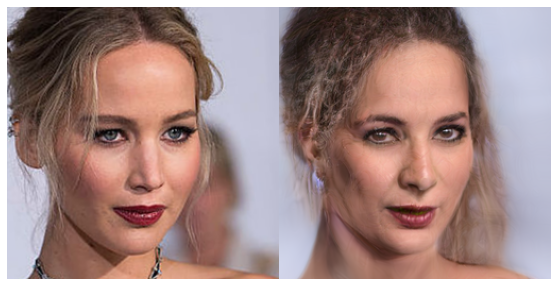

In [13]:
image_name = imgfile.strip('.jpg')
save_image(tensor2image(torch.cat([imgs_real, imgs_fakes], dim=2)),out=f'{image_name}-proj.jpg')

## With Naver Webtoon Model

Related Work

- [`happy-jihye/Cartoon-StyleGAN`](https://github.com/happy-jihye/Cartoon-StyleGAN)
- pre-trained model: [`jugyeong-30k`](https://drive.google.com/file/d/1ROTZDv0HaHS-brbkghh7tKD8PurLtDR1/view?usp=sharing)

In [42]:
# -------------
# Generator
# -------------

truncation = 0.5
truncation_mean = 4096
ckpt = "checkpoints/jugyeong-30k.pt"

ckpt = torch.load(ckpt, map_location=lambda storage, loc: storage)
conf = GANConfig(**ckpt["conf"])
g_webtoon = conf.generator.make().to(device)
g_webtoon.load_state_dict(ckpt["g_ema"], strict=False)

<All keys matched successfully>

In [56]:
trunc = generator.mean_latent(4096).detach().clone()

imgfile='sample/align-celeb-4.jpg'

img = transform(Image.open(imgfile).convert("RGB"))
imgs = img.unsqueeze(0).to(device)

with torch.no_grad():
    z0 = encoder(imgs)
    imgs_ffhq = generator(z0, 
                         input_is_latent=True,
                         truncation=truncation,
                         truncation_latent=trunc,
                         random_rgb=True)
    imgs_web = g_webtoon(z0, 
                         input_is_latent=True,
                         truncation=truncation,
                         truncation_latent=trunc,
                         random_rgb=True)
imgs_real = torch.cat([img for img in imgs], dim=1)
imgs_fakes = torch.cat([img_gen for img_gen in imgs_ffhq], dim=1)
imgs_fakes_web = torch.cat([img_gen for img_gen in imgs_web], dim=1)

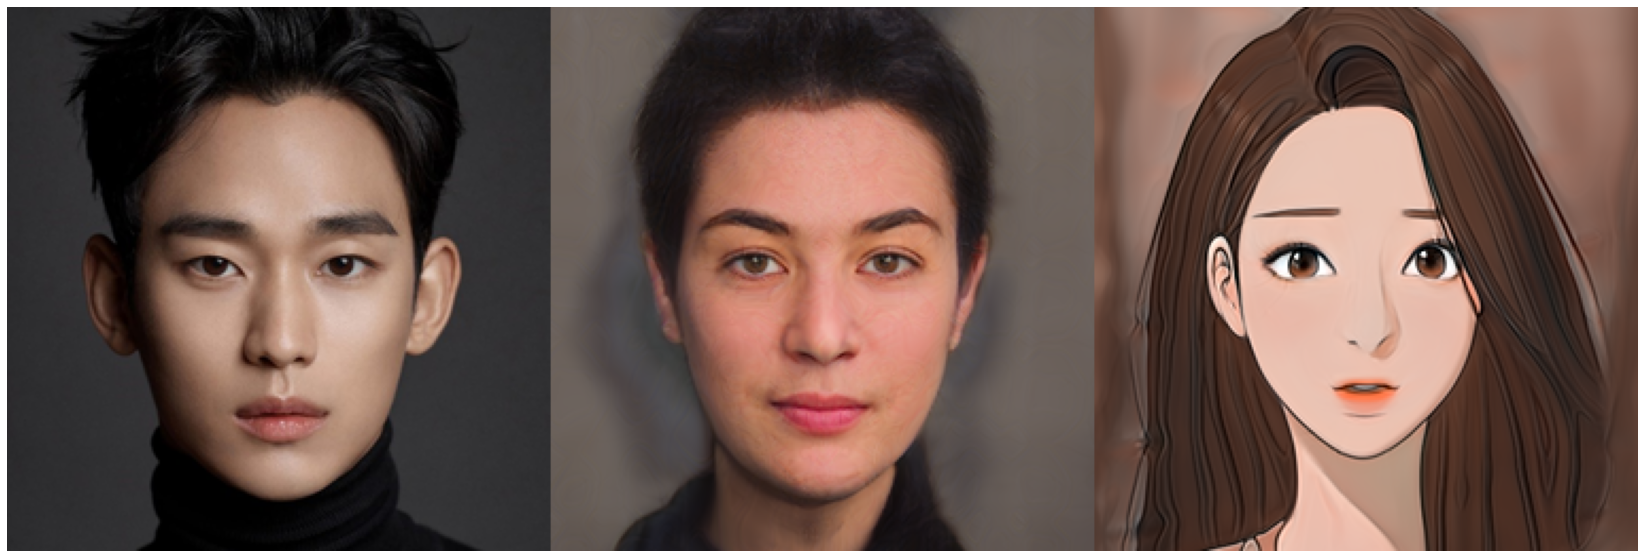

In [57]:
save_image(tensor2image(torch.cat([imgs_real, imgs_fakes, imgs_fakes_web], dim=2)),10, out='sample/image-web1-1.jpg')